In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip install opencv

In [ ]:
pip install  --upgrade pip

In [ ]:
pip install opencv-python

In [ ]:
!pip install tensorflow-gpu

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [3]:
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
NEGATIVE_PATH=os.path.join(desktop,"NegativeImages")
POSITIVE_PATH=os.path.join(desktop,"positiveImages")
ANCHOR_PATH=os.path.join(desktop,"AnchorImages")



In [ ]:

for directory in os.listdir(os.path.join('Face_recognition','lfw')):
         
    for file in os.listdir(os.path.join('Face_recognition','lfw',directory)): 
        
        EX_PATH=os.path.join('Face_recognition','lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)
        

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[120:120+250,200:200+250,:]

    # collect anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        folder_name = "AnchorImages"
        folder_path = os.path.join(desktop, folder_name)
        
        # create a unique file path
        imgname=os.path.join(folder_path,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        print(f"Anchor image saved: {imgname}")

    # collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        folder_name = "positiveImages"
        folder_path = os.path.join(desktop, folder_name)

        # create a unique file path
        imgname=os.path.join(folder_path,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        print(f"Positive image saved: {imgname}")
       
  
    cv2.imshow('Image collection',frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:

anchor_pattern = os.path.join(ANCHOR_PATH, "*.jpg")
positive_pattern = os.path.join(POSITIVE_PATH, "*.jpg")
negative_pattern = os.path.join(NEGATIVE_PATH, "*.jpg")
    
    
anchor = tf.data.Dataset.list_files(anchor_pattern).take(180)
positive = tf.data.Dataset.list_files(positive_pattern).take(180)
negative = tf.data.Dataset.list_files(negative_pattern).take(180)
    
   


In [5]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

In [6]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))) ))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [7]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [8]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [9]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [10]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [11]:
#training partition
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(18)
train_data=train_data.prefetch(6)

In [12]:
#  Testing partition
test_data=data.skip(round(len(data)*0.7))
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.prefetch(8)

In [13]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='Input_image')
    
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)

    
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c1)
    
    
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

   
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)


    return Model(inputs=inp,outputs=d1,name='embedding')



In [14]:
embedding=make_embedding()

In [15]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 43, 43, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 92416)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     378,540,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 379,215,040 (1.41 GB)

 Trainable params: 379,215,040 (1.41 GB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Distance Layer
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        
        return tf.math.abs(input_embedding - validation_embedding)




In [17]:
l1=L1Dist()

In [18]:
def make_siamese_model():
    
    input_image=Input(name='input_img',shape=(100,100,3))
    
    validation_image=Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    
    classifier=Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')
    

In [19]:
siamese_model=make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │     379,215,040 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 379,219,137 (1.41 GB)

 Trainable params: 379,219,137 (1.41 GB)

 Non-trainable params: 0 (0.00 B)

In [20]:
binary_cross_loss=tf.losses.BinaryCrossentropy()
opt=tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)


In [22]:
test_batch=train_data.as_numpy_iterator()
batch_1=test_batch.next()
#each batch in the dataset is compriswd of 16 samples , each of which contains an anchor image, a postive image or negative image and a label

In [ ]:
batch_1[2] # labels

In [23]:
losses=[]
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        
        #get anchor and positive/negative image
        X=batch[:2]
        # get label
        y=batch[2]

        # forward pass
        yhat=siamese_model(X,training=True)
        loss=binary_cross_loss(y,yhat)
    
        
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss 
   

In [24]:
def train(data,epochs):
    for epoch in range(1,epochs+1):
        print('\n Epoch {}/{}'.format(epoch,epochs))
        progbar=tf.keras.utils.Progbar(len(data))
        
        for idx,batch in enumerate(data):
            train_step(batch)            
            progbar.update(idx+1
                          )
            batch_wise_loss=train_step(batch).numpy()
            losses.append(batch_wise_loss)
            print(f", Loss:{batch_wise_loss:.4f}")
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

            

In [25]:
train(train_data,30)


 Epoch 1/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:25 7s/step, Loss:0.6222
 2/14 ━━━━━━━━━━━━━━━━━━━━ 1:33 8s/step, Loss:0.4988
 3/14 ━━━━━━━━━━━━━━━━━━━━ 1:25 8s/step, Loss:0.3811
 4/14 ━━━━━━━━━━━━━━━━━━━━ 1:15 8s/step, Loss:0.3067
 5/14 ━━━━━━━━━━━━━━━━━━━━ 1:09 8s/step, Loss:0.2132
 6/14 ━━━━━━━━━━━━━━━━━━━━ 1:02 8s/step, Loss:0.2396
 7/14 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step , Loss:0.1202
 8/14 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step, Loss:0.1166
 9/14 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step, Loss:0.1742
10/14 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step, Loss:0.2542
11/14 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step, Loss:0.1807
12/14 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step, Loss:0.0794
13/14 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step , Loss:0.0548
14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 9s/step
, Loss:0.1259

 Epoch 2/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step, Loss:0.0561
 2/14 ━━━━━━━━━━━━━━━━━━━━ 2:04 10s/step, Loss:0.0389
 3/14 ━━━━━━━━━━━━━━━━━━━━ 1:50 10s/step, Loss:0.0425
 4/14 ━━━━━━━━━━━━━━━━━━━━ 1:40 10s/step, Loss:0.0418
 5/14 ━━━━━━━━━━━━━━━━

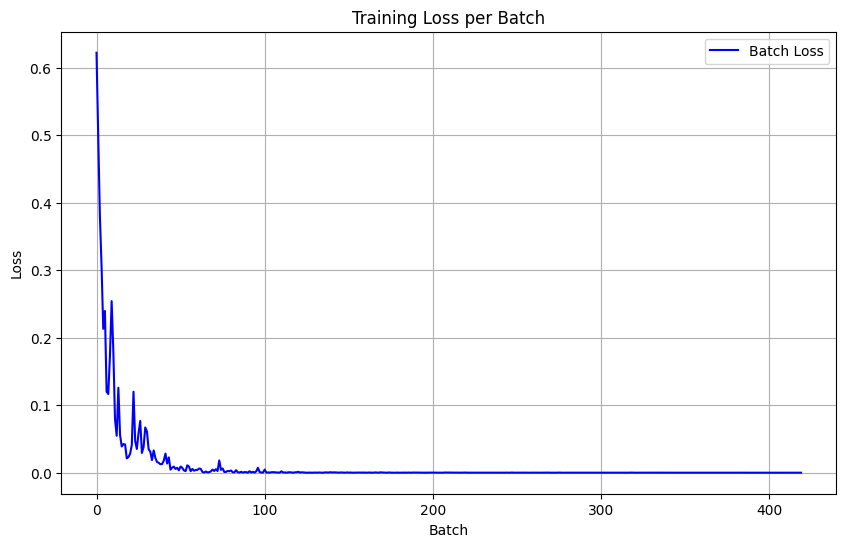

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(losses, 'b-', label='Batch Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# evaluating model
from tensorflow.keras.metrics import Precision,Recall

test_input,test_val,y_true=test_data.as_numpy_iterator().next()
test_input_reshaped = test_input.reshape(-1, 100, 100, 3) 
test_val_reshaped = test_val.reshape(-1, 100, 100, 3)

y_hat=siamese_model.predict([test_input_reshaped,test_val_reshaped])






In [ ]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]
m=Recall()
m.update_state(y_true,y_hat)
m.result().numpy
print(y_true)
print(y_hat)


In [27]:
# saving model
siamese_model.save('siamesemodel.h5')

In [28]:
# reload model
model=tf.keras.models.load_model('siamesemodel.h5',
                                 custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [29]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │     379,215,040 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 379,219,137 (1.41 GB)

 Trainable params: 379,219,137 (1.41 GB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# real time testing
#detection Threshold: Metric above which a prediction is considered positive
# Verification Threshold: proportion of positive predictions/ total positive samples

def verify(model,detection_threshold,verification_threshold):
    results=[]
    for image in os.listdir(os.path.join(desktop,'application_data','verification_image')):
        input_img=preprocess(os.path.join(desktop,'application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join(desktop,'application_data','verification_image',image))

        # make predictions
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)

    detection=np.sum(np.array(results)>detection_threshold)
        
    verification=detection/len(os.listdir(os.path.join(desktop,'application_data','verification_image')))
    verified=verification>verification_threshold
        
    return results,verified
    

In [ ]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Verification',frame)
    if cv2.waitKey(10) & 0xFF ==ord('v'):
        cv2.imwrite(os.path.join(desktop,'application_data','input_image','input_image.jpg'),frame)
        results,verified=verify(model,0.5,0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 